In [1]:
import random
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy
from scipy.io.wavfile import write
from scipy.fft import fft, fftfreq
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
sns.set_style('darkgrid')

In [2]:
from scipy.fft import fft, fftfreq
from scipy.fft import rfft, rfftfreq

In [24]:
import warnings
import tensorflow
from tensorflow.keras.models import Sequential, Model,  Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import concatenate,  multiply, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, MaxPooling2D, RepeatVector, SpatialDropout1D, SimpleRNN, GRU, Bidirectional, Reshape
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator, pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
warnings.filterwarnings('ignore')

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
tensorflow.keras.layers.Input

<function keras.engine.input_layer.Input(shape=None, batch_size=None, name=None, dtype=None, sparse=None, tensor=None, ragged=None, type_spec=None, **kwargs)>

# Functions

In [7]:
# Random generators

def make_window_ma(lower = 10, upper = 100):
    """
    Генерация размера скользящего окна, диапазоны указываем в аргументах
    :param lower: int
    :param upper: int
    :return: int
    """
    return random.randint(lower, upper)

def make_observing_window(lower = 10, upper = 300):
    """
    Генерация окна наблюдения. То окно, которое будем использовать для обнаружения нестационарности.
    :param lower: int
    :param upper: int
    :return: int
    """
    return random.randint(lower, upper)

def make_new_window_part(vars = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]):
    """
    Генерация размера скользящего окна, диапазоны указываем в аргументах
    :param lower: int
    :param upper: int
    :return: int
    """
    return random.choice(vars)

In [12]:
def pad_zeros(x, maxlen, how = 'pre'):
    """
    Дополняет ветор нулями до длины maxlen спереди или сзади.
    """
    x = np.array(x)
    lenx = x.shape[0]
    len0 = maxlen - lenx
    x0 = np.zeros(len0)
    if how == 'pre':
        x = np.concatenate([x0,x])
    elif how == 'after':
        x = np.concatenate([x,x0])
    return x

In [13]:
def get_corr_coef(data, back_steps): #  шаг смещения >= 0
    """
    Calculate correlation coefficient
    :param data: numpy 1D array
    :param back_steps:  autocorrelation shift
    :return: correlation coefficient, float
    """

    return np.corrcoef(data[back_steps:], data[:len(data) - back_steps])[0, 1]

def make_autocorrelation_dependence(x):
    """
    It takes a numpy array, and the maximum number of steps to calculate the autocorrelation function. The number of steps is expressed in terms of a fraction of the window (the length of the received signal).
    :param x: numpy 1D array
    :param steps_max_part_window: fraction of the array window, default 0.5
    :return: numpy array
    """
    corr = 1
    coefs = [corr]
    steps = 1
    while corr >= 0.5:
        corr = get_corr_coef(x, steps)
        steps += 1
        coefs.append(corr)
    return np.array(coefs)

In [17]:
def make_random_signal(length, ma):
    """
    The function creates a smooth signal obtained from noise.
    :param length: size of creating signal
    :param ma: value of moving average window
    :return: nunpy array 1D
    """

    x = np.random.normal(0,1,max(length*2, ma * 2))
    x = pd.Series(x).rolling(window = ma).mean().dropna().values
    abs_x = np.abs(x)
    x = x[:length]
    max_value =abs_x.max()
    x = x/max_value

    return x

In [18]:
def make_abs_spectr(signal, normalise = True):
    """
    Function receive numpy array signal, calculate abs FFT.
    If you want you may normalise it, as default
    :param signal: numpy array
    :param normalize: normalise [0,1]
    :return: numpy array FFT
    """
    signal_fft = np.abs(rfft(signal))
    if normalise:
        signal_fft = signal_fft / signal_fft.max()
    signal_fft = np.array(signal_fft)
    return signal_fft

In [19]:
def make_data_single_signal(N, lower_ma = 10, upper_ma = 100, lower_window = 10, upper_window = 300, padd_len = None):
    """
    Создание обучающего датасета. Часть датасета является одним сигналом, часть - сшивка двух сигналов.

    """

    # First signal
    X = []
    y = []
    for i in range(int(N/2)):
        ma = make_window_ma(lower = lower_ma, upper = upper_ma)
        window = make_observing_window(lower = lower_window, upper = upper_window)
        signal = make_random_signal(window, ma)
        X.append(signal.tolist())
        y.append(0)

    #Second signal
    for i in range(int(N/2)):
        ma1 = make_window_ma(lower = lower_ma, upper = upper_ma)
        ma2 = make_window_ma(lower = lower_ma, upper = upper_ma)
        while ma1 == ma2:
            ma2 = make_window_ma(lower = lower_ma, upper = upper_ma)

        window = make_observing_window(lower = lower_window, upper = upper_window)
        signal1 = make_random_signal(window, ma1)
        signal2 = make_random_signal(window, ma2)
        new_window_part = make_new_window_part()
        t2 = int(new_window_part * window)
        t1 = window - t2
        signal = np.concatenate([signal1[-t1:], signal2[-t2:]])
        X.append(signal.tolist())
        y.append(1)

    maxlen = max([len(i) for i in X])
    X = pad_sequences(X, dtype='float', maxlen=padd_len) if padd_len  else pad_sequences(X, dtype='float', maxlen=maxlen)

    X = np.array(X)
    # shuffle data
    X = pd.DataFrame(X)
    X['y'] = y
    X = X.sample(frac=1)
    X = X.sample(frac=1)

    y = X.y.values
    y = to_categorical(y)
    X = X.drop('y', axis=1).values

    return X, y

In [26]:
def compile_and_learn(model, X_train,  y_train, X_test, y_test,  epochs, optimizer, loss, metrics, batch_size=16):

    # Компиляция модели
    model.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)
    model.summary()

    # Обучение модели
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        verbose = 1,
                        callbacks = [EarlyStopping(monitor='val_loss', patience=7, mode = 'min', verbose=0),
                                     ModelCheckpoint(filepath="best_model.hdf5", monitor='val_loss' , save_best_only = True, mode = 'min', verbose = 0),
                                     ReduceLROnPlateau(monitor='val_loss' , mode = 'min', factor=0.5, patience=5, verbose = 1)]
                        )

    f, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(15,5))
    axes[0].plot(history.history['loss'], label='Ошибка на обучающем наборе')
    axes[0].plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
    axes[0].set_xlabel('Эпоха')
    axes[0].set_ylabel('Ошибка')
    axes[0].legend()

    axes[1].plot(history.history['accuracy'], label='Точность на обучающем наборе')
    axes[1].plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
    axes[1].set_xlabel('Эпоха')
    axes[1].set_ylabel('Точность')
    axes[1].legend()

    print('Тестовые данные')
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(classification_report(np.argmax(y_test, axis=1), y_pred))
    print('Тренировочные данные')
    y_pred = np.argmax(model.predict(X_train), axis=1)
    print(classification_report(np.argmax(y_train, axis=1), y_pred))
    return model

# Simple data

In [21]:
X_train,y_train = make_data_single_signal(15000, padd_len=300)
X_test,y_test = make_data_single_signal(5000, padd_len=300)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(15000, 300)
(15000, 2)
(5000, 300)
(5000, 2)


# LSTM 1

In [27]:
input = Input(X_train.shape[1])

x = Reshape((X_train.shape[1],1))(input)

x = LSTM(64, return_sequences=True)(x)
x = LSTM(64)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(2, activation='softmax')(x)
model = Model(input,x)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 reshape_1 (Reshape)         (None, 300, 1)            0         
                                                                 
 lstm_2 (LSTM)               (None, 300, 64)           16896     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 130 

In [28]:
compile_and_learn(model, X_train, y_train, X_test, y_test, epochs = 15, optimizer = Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'], batch_size = 32)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 reshape_1 (Reshape)         (None, 300, 1)            0         
                                                                 
 lstm_2 (LSTM)               (None, 300, 64)           16896     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 130 

KeyboardInterrupt: 

# LSTM 2

In [30]:
model = Sequential()
model.add(Reshape((X_train.shape[1],1)))
#model.add(BatchNormalization())
# Два двунаправленных рекуррентных слоя LSTM
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))


Epoch 1/15
32/32 [==============================] - 26s 623ms/step - loss: 0.6961 - accuracy: 0.4900 - val_loss: 0.6935 - val_accuracy: 0.4740
Epoch 2/15
32/32 [==============================] - 18s 568ms/step - loss: 0.6988 - accuracy: 0.4910 - val_loss: 0.6934 - val_accuracy: 0.4840
Epoch 3/15
32/32 [==============================] - 20s 642ms/step - loss: 0.6939 - accuracy: 0.5180 - val_loss: 0.6929 - val_accuracy: 0.5160
Epoch 4/15
32/32 [==============================] - 25s 770ms/step - loss: 0.6933 - accuracy: 0.5140 - val_loss: 0.6931 - val_accuracy: 0.4840
Epoch 5/15
32/32 [==============================] - 23s 738ms/step - loss: 0.6940 - accuracy: 0.4810 - val_loss: 0.6922 - val_accuracy: 0.5060
Epoch 6/15
32/32 [==============================] - 26s 815ms/step - loss: 0.6884 - accuracy: 0.5410 - val_loss: 0.6905 - val_accuracy: 0.5240
Epoch 7/15
32/32 [==============================] - 20s 628ms/step - loss: 0.6920 - accuracy: 0.5280 - val_loss: 0.6914 - val_accuracy: 0.4920

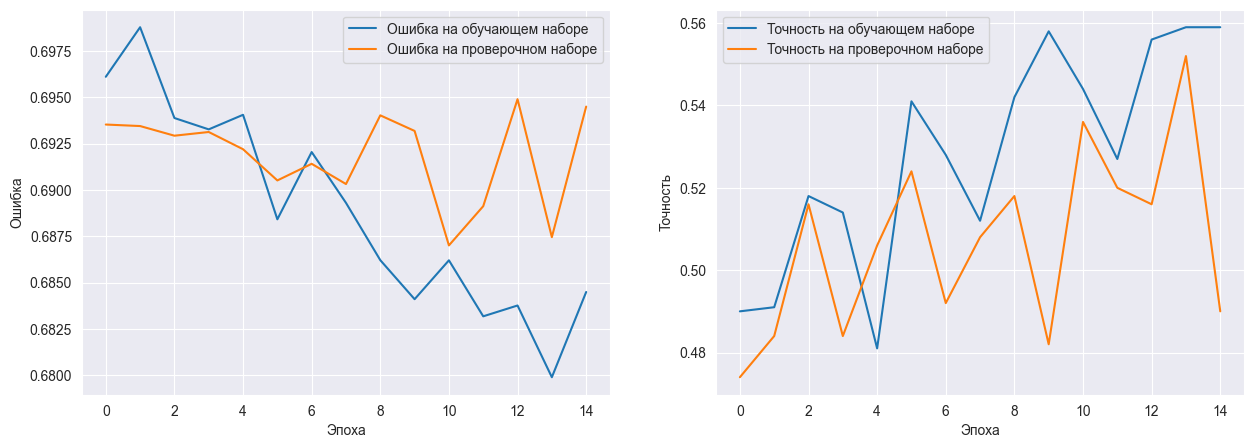

In [31]:
compile_and_learn2(model, X_train, y_train, X_test, y_test, epochs = 15, optimizer = Adam(lr=1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'], batch_size = 32)

# Conv1D 1

In [122]:
model = Sequential()
model.add(Reshape((X_train.shape[1],1)))
model.add(SpatialDropout1D(0.2))
model.add(BatchNormalization())
# Два слоя одномерной свертки Conv1D
model.add(Conv1D(30, 3, activation='relu', padding='same'))
model.add(Conv1D(30, 3, activation='relu'))
# Слой подвыборки/пулинга с функцией максимума
model.add(MaxPooling1D(2))
model.add(Conv1D(60, 3, activation='relu', padding='same'))
model.add(Conv1D(60, 3, activation='relu'))
#model_Conv_1.add(MaxPooling1D(2))
# Рекуррентный слой LSTM
#model_Conv_1.add(LSTM(64, return_sequences=1))

model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

Epoch 1/15
235/235 [==============================] - 18s 67ms/step - loss: 0.7276 - accuracy: 0.5171 - val_loss: 0.6927 - val_accuracy: 0.5004 - lr: 5.0000e-05
Epoch 2/15
235/235 [==============================] - 16s 68ms/step - loss: 0.6945 - accuracy: 0.5448 - val_loss: 0.6879 - val_accuracy: 0.5292 - lr: 5.0000e-05
Epoch 3/15
235/235 [==============================] - 16s 69ms/step - loss: 0.6728 - accuracy: 0.5787 - val_loss: 0.6826 - val_accuracy: 0.5554 - lr: 5.0000e-05
Epoch 4/15
235/235 [==============================] - 16s 68ms/step - loss: 0.6533 - accuracy: 0.6027 - val_loss: 0.6683 - val_accuracy: 0.5802 - lr: 5.0000e-05
Epoch 5/15
235/235 [==============================] - 16s 67ms/step - loss: 0.6408 - accuracy: 0.6135 - val_loss: 0.6570 - val_accuracy: 0.6038 - lr: 5.0000e-05
Epoch 6/15
235/235 [==============================] - 16s 67ms/step - loss: 0.6192 - accuracy: 0.6402 - val_loss: 0.6496 - val_accuracy: 0.6146 - lr: 5.0000e-05
Epoch 7/15
235/235 [==============

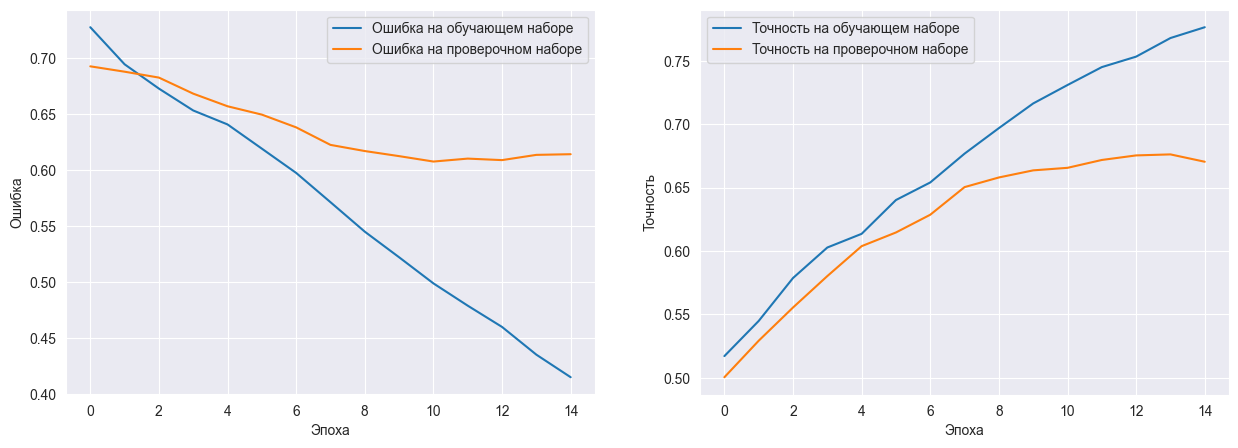

In [123]:
compile_and_learn2(model, X_train, y_train, X_test, y_test, epochs = 15, optimizer = Adam(lr=5e-5), loss = 'categorical_crossentropy', metrics = ['accuracy'], batch_size = 64)

In [124]:
model.load_weights("best_model.hdf5")

# Dense 1

input1 = Input(X_train.shape[1])
l = Dense(128, activation="relu")(input1)
l = Dropout(0.25)(l)
l = Dense(64, activation="relu")(input1)
l = Dropout(0.25)(l)
#l = BatchNormalization()(l)
l = Dense(2, activation = 'softmax')(l)
model = Model(input1, l)

Epoch 1/25
235/235 [==============================] - 1s 3ms/step - loss: 0.7054 - accuracy: 0.5214 - val_loss: 0.6944 - val_accuracy: 0.5270 - lr: 1.0000e-04
Epoch 2/25
235/235 [==============================] - 1s 2ms/step - loss: 0.6945 - accuracy: 0.5359 - val_loss: 0.6898 - val_accuracy: 0.5374 - lr: 1.0000e-04
Epoch 3/25
235/235 [==============================] - 1s 3ms/step - loss: 0.6900 - accuracy: 0.5438 - val_loss: 0.6873 - val_accuracy: 0.5444 - lr: 1.0000e-04
Epoch 4/25
235/235 [==============================] - 1s 2ms/step - loss: 0.6860 - accuracy: 0.5557 - val_loss: 0.6859 - val_accuracy: 0.5456 - lr: 1.0000e-04
Epoch 5/25
235/235 [==============================] - 1s 2ms/step - loss: 0.6822 - accuracy: 0.5642 - val_loss: 0.6848 - val_accuracy: 0.5548 - lr: 1.0000e-04
Epoch 6/25
235/235 [==============================] - 1s 2ms/step - loss: 0.6829 - accuracy: 0.5593 - val_loss: 0.6846 - val_accuracy: 0.5502 - lr: 1.0000e-04
Epoch 7/25
235/235 [==========================

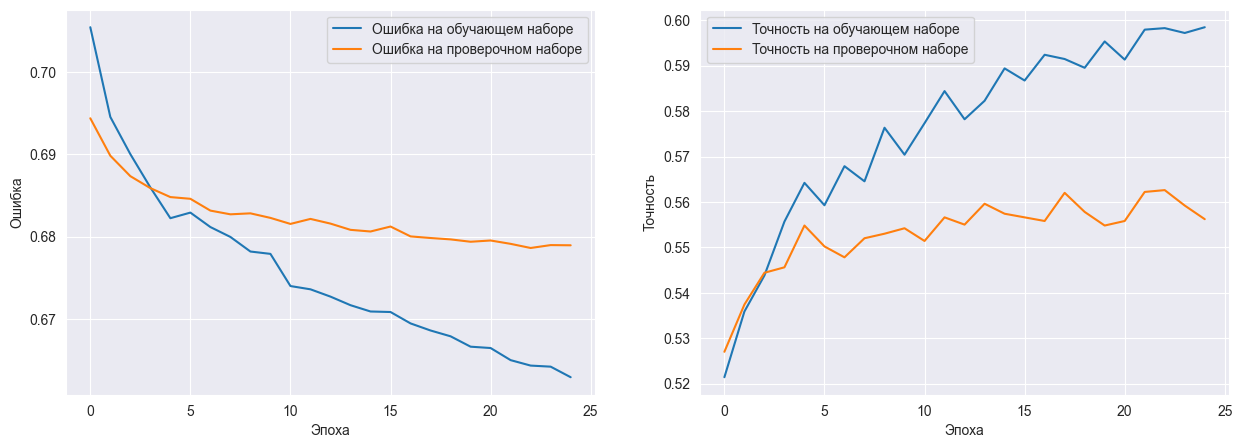

In [180]:
compile_and_learn2(model, X_train, y_train, X_test, y_test, epochs = 25, optimizer = Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'], batch_size = 64)

In [181]:
model.load_weights("best_model.hdf5")

# Differencies

In [194]:
X_train,y_train, _, _, _, _ = make_data_differs_signal(15000, padd_len=300)
X_test,y_test, ma_1_test, ma_2_test, window_s_test, new_window_parts_test = make_data_single_signal(5000, padd_len=300)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(15000, 300)
(15000, 2)
(5000, 300)
(5000, 2)


# Conv1d

In [197]:
model = Sequential()
model.add(Reshape((X_train.shape[1],1)))
model.add(SpatialDropout1D(0.2))
model.add(BatchNormalization())
# Два слоя одномерной свертки Conv1D
model.add(Conv1D(30, 3, activation='relu', padding='same'))
model.add(Conv1D(30, 3, activation='relu'))
# Слой подвыборки/пулинга с функцией максимума
model.add(MaxPooling1D(2))
model.add(Conv1D(60, 3, activation='relu', padding='same'))
model.add(Conv1D(60, 3, activation='relu'))
#model_Conv_1.add(MaxPooling1D(2))
# Рекуррентный слой LSTM
#model_Conv_1.add(LSTM(64, return_sequences=1))

model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

In [198]:
compile_and_learn2(model, X_train, y_train, X_test, y_test, epochs = 15, optimizer = Adam(lr=5e-5), loss = 'categorical_crossentropy', metrics = ['accuracy'], batch_size = 64)

Epoch 1/15
235/235 [==============================] - 17s 65ms/step - loss: 0.7148 - accuracy: 0.5459 - val_loss: 0.6960 - val_accuracy: 0.5016 - lr: 5.0000e-05
Epoch 2/15
235/235 [==============================] - 15s 64ms/step - loss: 0.6357 - accuracy: 0.6240 - val_loss: 0.7970 - val_accuracy: 0.4992 - lr: 5.0000e-05
Epoch 3/15
235/235 [==============================] - 15s 64ms/step - loss: 0.5869 - accuracy: 0.6667 - val_loss: 1.0402 - val_accuracy: 0.5060 - lr: 5.0000e-05
Epoch 4/15
 72/235 [========>.....................] - ETA: 10s - loss: 0.5611 - accuracy: 0.6764

KeyboardInterrupt: 

# LSTM1

In [201]:
input = Input(X_train.shape[1])

x = Reshape((X_train.shape[1],1))(input)

x = LSTM(64, return_sequences=True)(x)
x = LSTM(64)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(2, activation='softmax')(x)
model = Model(input,x)

model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 300)]             0         
                                                                 
 reshape_31 (Reshape)        (None, 300, 1)            0         
                                                                 
 lstm_14 (LSTM)              (None, 300, 64)           16896     
                                                                 
 lstm_15 (LSTM)              (None, 64)                33024     
                                                                 
 dense_99 (Dense)            (None, 64)                4160      
                                                                 
 dropout_87 (Dropout)        (None, 64)                0         
                                                                 
 dense_100 (Dense)           (None, 2)                 130

In [202]:
compile_and_learn2(model, X_train, y_train, X_test, y_test, epochs = 15, optimizer = Adam(lr=5e-5), loss = 'categorical_crossentropy', metrics = ['accuracy'], batch_size = 64)

Epoch 1/15
235/235 [==============================] - 105s 434ms/step - loss: 0.6931 - accuracy: 0.4994 - val_loss: 0.6959 - val_accuracy: 0.5000 - lr: 5.0000e-05
Epoch 2/15
235/235 [==============================] - 112s 476ms/step - loss: 0.6927 - accuracy: 0.5137 - val_loss: 0.7092 - val_accuracy: 0.5000 - lr: 5.0000e-05
Epoch 3/15
235/235 [==============================] - 115s 489ms/step - loss: 0.6919 - accuracy: 0.5237 - val_loss: 0.7608 - val_accuracy: 0.4998 - lr: 5.0000e-05
Epoch 4/15
 15/235 [>.............................] - ETA: 1:14 - loss: 0.6907 - accuracy: 0.5458

KeyboardInterrupt: 

# Dense 1

In [203]:
input1 = Input(X_train.shape[1])
l = Dense(128, activation="relu")(input1)
l = Dropout(0.25)(l)
l = Dense(64, activation="relu")(input1)
l = Dropout(0.25)(l)
#l = BatchNormalization()(l)
l = Dense(2, activation = 'softmax')(l)
model = Model(input1, l)

Epoch 1/25
235/235 [==============================] - 1s 3ms/step - loss: 0.6963 - accuracy: 0.4961 - val_loss: 0.7476 - val_accuracy: 0.4870 - lr: 1.0000e-04
Epoch 2/25
235/235 [==============================] - 1s 2ms/step - loss: 0.6934 - accuracy: 0.5035 - val_loss: 0.7483 - val_accuracy: 0.4880 - lr: 1.0000e-04
Epoch 3/25
235/235 [==============================] - 1s 3ms/step - loss: 0.6916 - accuracy: 0.5178 - val_loss: 0.7506 - val_accuracy: 0.4864 - lr: 1.0000e-04
Epoch 4/25
235/235 [==============================] - 1s 2ms/step - loss: 0.6901 - accuracy: 0.5242 - val_loss: 0.7537 - val_accuracy: 0.4866 - lr: 1.0000e-04
Epoch 5/25
235/235 [==============================] - 1s 2ms/step - loss: 0.6870 - accuracy: 0.5459 - val_loss: 0.7585 - val_accuracy: 0.4866 - lr: 1.0000e-04
Epoch 6/25
233/235 [============================>.] - ETA: 0s - loss: 0.6848 - accuracy: 0.5614
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
235/235 [========================

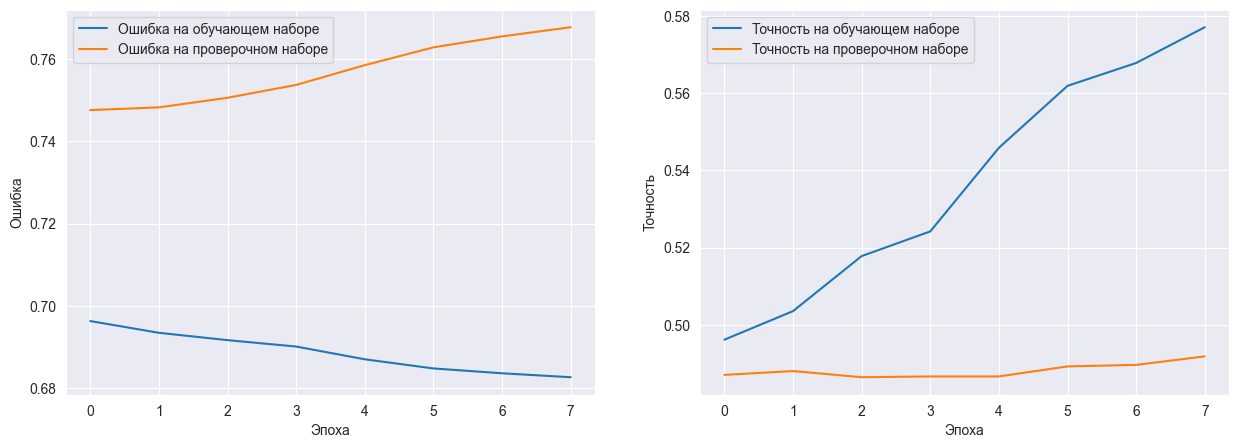

In [204]:
compile_and_learn2(model, X_train, y_train, X_test, y_test, epochs = 25, optimizer = Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'], batch_size = 64)

# 2 parts of signal

In [21]:
def make_datas_2_parts_of_signal(N, lower_ma = 10, upper_ma = 100, lower_window = 10, upper_window = 300, padd_len = None, part_second_window = 0.3):
    """
    Создание обучающего датасета. Часть датасета является одним сигналом, часть - сшивка двух сигналов.

    """

    # First signal
    left_part_of_signal = []
    right_part_of_signal = []
    y = []
    for i in range(int(N/2)):
        ma = make_window_ma(lower = lower_ma, upper = upper_ma)
        window = make_observing_window(lower = lower_window, upper = upper_window)

        signal = make_random_signal(window, ma)

        # Раскидываем сигналы внутри окна по половинкам
        t2 = int(window * part_second_window)
        t1 = t2 - window
        left_part_of_signal.append(signal.tolist()[:t1])
        right_part_of_signal.append(signal.tolist()[t1:])
        y.append(0)

    #Second signal
    for i in range(int(N/2)):
        ma1 = make_window_ma(lower = lower_ma, upper = upper_ma)
        ma2 = make_window_ma(lower = lower_ma, upper = upper_ma)
        while ma1 != ma2:
            ma2 = make_window_ma(lower = lower_ma, upper = upper_ma)

        window = make_observing_window(lower = lower_window, upper = upper_window)
        signal1 = make_random_signal(window, ma1)

        signal2 = make_random_signal(window, ma2)
        new_window_part = make_new_window_part()
        t2 = int(new_window_part * window)
        t1 = window - t2

        signal = np.concatenate([signal1[-t1:], signal2[-t2:]])

        # Раскидываем сигналы внутри окна по половинкам
        t2 = int(window * part_second_window)
        t1 = t2 - window
        left_part_of_signal.append(signal.tolist()[:t1])
        right_part_of_signal.append(signal.tolist()[t1:])
        y.append(0)

    maxlen1 = max([len(i) for i in left_part_of_signal])
    maxlen2 = max([len(i) for i in right_part_of_signal])
    maxlen = max(maxlen1, maxlen2)

    left_part_of_signal = pad_sequences(left_part_of_signal, dtype='float', maxlen=int(round(padd_len/2))+1 ) if padd_len  else pad_sequences(left_part_of_signal, dtype='float', maxlen=maxlen)
    right_part_of_signal = pad_sequences(right_part_of_signal, dtype='float', maxlen=int(round(padd_len/2))+1 ) if padd_len  else pad_sequences(right_part_of_signal, dtype='float', maxlen=maxlen)
    left_part_of_signal = np.array(left_part_of_signal)
    right_part_of_signal = np.array(right_part_of_signal)

    left_shape = left_part_of_signal.shape
    right_shape = right_part_of_signal.shape

    # shuffle data
    X = np.concatenate([left_part_of_signal, right_part_of_signal], axis=1)
    X = pd.DataFrame(X)
    X['y'] = y
    X = X.sample(frac=1)
    X = X.sample(frac=1)

    y = X.iloc[:, -1].values
    y = to_categorical(y)
    X = X.drop('y', axis=1).values


    X1 = X[:, :left_shape[1]]
    X2 = X[:, left_shape[1]:]

    y = to_categorical(y)

    return X1, X2, y

In [231]:
X_train_1, X_train_2,y_train = make_datas_2_parts_of_signal(15000, lower_ma = 10, upper_ma = 100, lower_window = 10, upper_window = 300, padd_len = 300, part_second_window = 0.3)
X_test_1, X_test_2,y_test = make_datas_2_parts_of_signal(3000, lower_ma = 10, upper_ma = 100, lower_window = 10, upper_window = 300, padd_len = 300, part_second_window = 0.3)
print(X_train_1.shape, X_train_2.shape)
print(y_train.shape)
print(X_test_1.shape, X_test_2.shape)
print(y_test.shape)

(15000, 151) (15000, 151)
(15000, 2)
(3000, 151) (3000, 151)
(3000, 2)


# LSTM 1

In [23]:
input1 = tensorflow.keras.layers.Input(X_train_1.shape[1])
input2 = tensorflow.keras.layers.Input(X_train_2.shape[1])

x1 = Reshape((X_train_1.shape[1],1))(input1)
x2 = Reshape((X_train_2.shape[1],1))(input2)

x1 = LSTM(64, return_sequences=True)(x1)
x1 = LSTM(64)(x1)

x2 = LSTM(64, return_sequences=True)(x2)
x2 = LSTM(64)(x2)

x = concatenate([x1,x2])
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(2, activation='softmax')(x)
model = Model([input1,input2],x)

model.summary()

NameError: name 'X_train_1' is not defined

In [22]:
def compile_and_learn2(model, X_train_1, X_train_2,  y_train, X_test_1, X_test_2, y_test,  epochs, optimizer, loss, metrics, batch_size=32):

    # Компиляция модели
    model.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)
    #model.summary()

    # Обучение модели
    history = model.fit([X_train_1, X_train_2],
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=([X_test_1, X_test_2], y_test),
                        verbose = 1,
                        callbacks = [EarlyStopping(monitor='val_loss', patience=7, mode = 'min', verbose=0),
                                     ModelCheckpoint(filepath="best_model.hdf5", monitor='val_loss' , save_best_only = True, mode = 'min', verbose = 0),
                                     ReduceLROnPlateau(monitor='val_loss' , mode = 'min', factor=0.5, patience=5, verbose = 1)]
                        )

    f, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(15,5))
    axes[0].plot(history.history['loss'], label='Ошибка на обучающем наборе')
    axes[0].plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
    axes[0].set_xlabel('Эпоха')
    axes[0].set_ylabel('Ошибка')
    axes[0].legend()

    axes[1].plot(history.history['accuracy'], label='Точность на обучающем наборе')
    axes[1].plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
    axes[1].set_xlabel('Эпоха')
    axes[1].set_ylabel('Точность')
    axes[1].legend()

    print('Тестовые данные')
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(classification_report(np.argmax(y_test, axis=1), y_pred))
    print('Тренировочные данные')
    y_pred = np.argmax(model.predict(X_train), axis=1)
    print(classification_report(np.argmax(y_train, axis=1), y_pred))
    return model

Epoch 1/15
235/235 [==============================] - 66s 256ms/step - loss: 6.4161e-06 - accuracy: 1.0000 - val_loss: 7.7883e-08 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 2/15
235/235 [==============================] - 60s 254ms/step - loss: 6.3757e-07 - accuracy: 1.0000 - val_loss: 2.2570e-08 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 3/15
235/235 [==============================] - 63s 266ms/step - loss: 2.3464e-07 - accuracy: 1.0000 - val_loss: 1.0292e-08 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 4/15
235/235 [==============================] - 63s 266ms/step - loss: 1.7563e-07 - accuracy: 1.0000 - val_loss: 5.6028e-09 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 5/15
235/235 [==============================] - 63s 270ms/step - loss: 9.6741e-08 - accuracy: 1.0000 - val_loss: 3.7352e-09 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 6/15
235/235 [==============================] - ETA: 0s - loss: 8.6878e-08 - accuracy: 1.0000
Epoch 6: ReduceLROnPlateau reducing learning rate 

ValueError: in user code:

    File "D:\Аспирантура\codes\signal_processing_with_NN\venv\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "D:\Аспирантура\codes\signal_processing_with_NN\venv\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Аспирантура\codes\signal_processing_with_NN\venv\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "D:\Аспирантура\codes\signal_processing_with_NN\venv\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "D:\Аспирантура\codes\signal_processing_with_NN\venv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "D:\Аспирантура\codes\signal_processing_with_NN\venv\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_14" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 300) dtype=float32>]


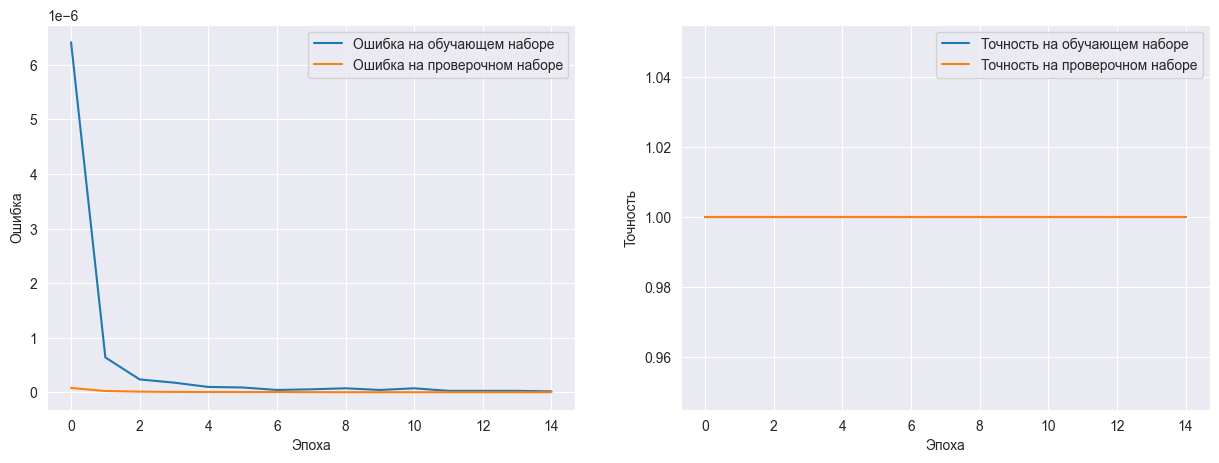

In [235]:
compile_and_learn2(model, X_train_1, X_train_2, y_train, X_test_1, X_test_2, y_test, epochs = 15, optimizer = Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'], batch_size = 64)

In [ ]:
model.load_weights("best_model.hdf5")

In [242]:
input('Введите длину сигнала от 10 до 300')

TypeError: 'KerasTensor' object is not callable

In [23]:
def check_model(part_second_window = 0.3):
    window = int(input('Введите длину сигнала от 10 до 300'))
    flag = int(input('Сколько сигналов присутствует в окне (1 или 2) ?'))
    signals = []
    if flag == 1:

        ma = int(input("Какое окно сглаживания от 10 до 300 ?"))

        signal = make_random_signal(window, ma)

        # Раскидываем сигналы внутри окна по половинкам
        t2 = int(window * part_second_window)
        t1 = t2 - window
        signals.append(signal.tolist()[:t1])
        signals.append(signal.tolist()[t1:])
        signals = pad_sequences(signals, dtype='float', maxlen=int(round(300/2))+1 )
        X_train_1 = np.array(signals[0]).reshape(-1,1)
        X_train_2 = np.array(signals[1]).reshape(-1,1)
        print(X_train_1.shape)
        print(X_train_2.shape)


    elif flag == 2:
        ma1 = int(input("Какое окно сглаживания первого сигнала от 10 до 300 ?"))
        ma2 = int(input("Какое окно сглаживания второго сигнала от 10 до 300 ?"))
        # while ma1 != ma2:
        #     ma2 = int(input("Какое окно сглаживания второго сигнала от 10 до 300 ?"))

        signal1 = make_random_signal(window, ma1)
        signal2 = make_random_signal(window, ma2)
        new_window_part = float(input("Какую долю окна занимает второй сигнал? от 0.01 до 0.5 ?"))
        t2 = int(new_window_part * window)
        t1 = window - t2

        signal = np.concatenate([signal1[-t1:], signal2[-t2:]])
        # Раскидываем сигналы внутри окна по половинкам
        t2 = int(window * part_second_window)
        t1 = t2 - window
        signals.append(signal.tolist()[:t1])
        signals.append(signal.tolist()[t1:])
        signals = pad_sequences(signals, dtype='float', maxlen=int(round(300/2))+1 )
        X_train_1 = np.array(signals[0]).reshape(-1,1)
        X_train_2 = np.array(signals[1]).reshape(-1,1)
        print(X_train_1.shape)
        print(X_train_2.shape)


    #############################################
    input1 = tensorflow.keras.layers.Input(X_train_1.shape[1])
    input2 = tensorflow.keras.layers.Input(X_train_2.shape[1])

    x1 = Reshape((X_train_1.shape[1],1))(input1)
    x2 = Reshape((X_train_2.shape[1],1))(input2)

    x1 = LSTM(64, return_sequences=True)(x1)
    x1 = LSTM(64)(x1)

    x2 = LSTM(64, return_sequences=True)(x2)
    x2 = LSTM(64)(x2)

    x = concatenate([x1,x2])
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(2, activation='softmax')(x)
    model = Model([input1,input2],x)



    model.load_weights("best_model.hdf5")

    ################################################

    plt.plot(signal)
    res =  model.predict([X_train_1, X_train_2])

    print(res)
    return model

(151, 1)
(151, 1)
5/5 [==============================] - 2s 3ms/step
[[0.4184986  0.5815014 ]
 [0.4184986  0.5815014 ]
 [0.4184986  0.5815014 ]
 [0.4184986  0.5815014 ]
 [0.4184986  0.5815014 ]
 [0.4184986  0.5815014 ]
 [0.4184986  0.5815014 ]
 [0.4184986  0.5815014 ]
 [0.4184986  0.5815014 ]
 [0.4184986  0.5815014 ]
 [0.4184986  0.5815014 ]
 [0.4167697  0.58323026]
 [0.41747078 0.5825293 ]
 [0.41667202 0.58332795]
 [0.4171442  0.58285576]
 [0.4168888  0.5831112 ]
 [0.41727284 0.58272713]
 [0.41745868 0.58254135]
 [0.41760162 0.5823984 ]
 [0.4171873  0.5828127 ]
 [0.41748562 0.5825144 ]
 [0.41752273 0.5824773 ]
 [0.41744277 0.5825572 ]
 [0.41734403 0.5826559 ]
 [0.4169667  0.5830333 ]
 [0.41724065 0.5827594 ]
 [0.4178197  0.5821803 ]
 [0.4179278  0.5820722 ]
 [0.41789111 0.58210886]
 [0.4170481  0.5829519 ]
 [0.41710702 0.58289295]
 [0.4175182  0.5824818 ]
 [0.41755348 0.58244646]
 [0.41766232 0.5823377 ]
 [0.4176464  0.5823536 ]
 [0.4170177  0.58298236]
 [0.41654682 0.5834532 ]
 [0.41

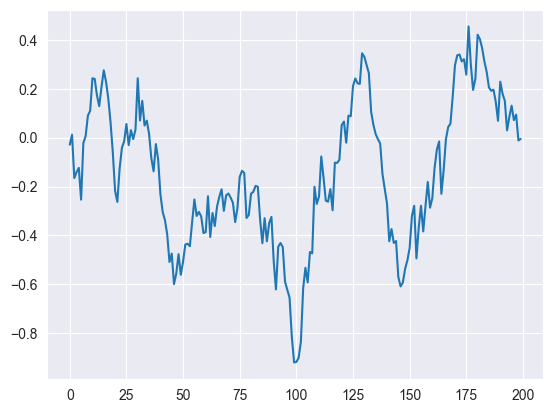

In [24]:
model = check_model()

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 1)         0           ['input_1[0][0]']                
                                                                                                  
 reshape_1 (Reshape)            (None, 1, 1)         0           ['input_2[0][0]']                
                                                                                              